In [221]:
%run ./const
%run ./param
import numpy as np
import glob
from scipy import integrate, interpolate
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}  \usepackage[T1]{fontenc}')

matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 1.5

import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import palettable
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy import optimize
import cmasher as cmr
import matplotlib.font_manager
from numpy import random
from scipy.stats import lognorm
from scipy.stats import norm
import scipy.optimize as opt

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from ipynb.fs.full.utils import Matrix3D
import time

###########################
gamma   = 5/3.
kb      = 1.3806488e-16
mp      = 1.67373522381e-24
km      = 1e5
s       = 1
yr      = 3.1536e7
Myr     = 3.1536e13
Gyr     = 3.1536e16
pc      = 3.086e18
kpc     = 1.0e3 * pc
Mpc     = 1.0e6 * pc
H0      = 67.74*km/s/Mpc
Om      = 0.3075
OL      = 1 - Om
G       = 6.673e-8
Msun    = 2.e33
fb      = 0.158
keV     = 1.60218e-9
###########################


###########################
mu          = 0.62
metallicity = 10**-0.5
muH         = 1/0.75
###########################

const = Const()
pm = Param("Inputs", const).paramDict

In [222]:
class Cooling:
    def __init__(self, fname):
        file = glob.glob(fname) ## CHANGE FOR WHERE YOU WANT TO KEEP IT
        if len(file) > 0:
            data = np.load(file[0])
            Lambda_tab = data['Lambda_tab']
            redshifts  = data['redshifts']
            Zs         = data['Zs']
            log_Tbins  = data['log_Tbins']
            log_nHbins = data['log_nHbins']    
            self.Lambda     = interpolate.RegularGridInterpolator((log_nHbins,log_Tbins,Zs,redshifts), Lambda_tab, bounds_error=False, fill_value=1e-30)
        else:
            print("Cooling curve file not found")
            
    def tcool_P(self, T,P, metallicity, mu, muH):
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        return 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), metallicity,0)))

In [223]:
coolCurve = Cooling('Lambda_tab_redshifts.npz')
coolCurve.Lambda((-1, np.log10(1e6), 0.02, 0))

array(9.08173569e-24)

In [224]:
class Wind:      
    
    def __init__(self, dr, const, pm):
        self.dr = dr        
        self.r0 = pm['SONIC_POINT']   # sonic point
        self.gamma = 5/3     # adiabatic index
        epsilon = 1e-5   
        Mach0 = 1       
        Mach = Mach0 * (1+epsilon)        
        beta = pm['BETA']      # mass loading 
        alpha = pm['ALPHA']     # energy loading
        SFR = pm['SFR']       # star formation rate
        Mdot = pm['MDOT']        # mass injection rate
        Edot = pm['EDOT']    # energy injection rate
        v0 = (Mdot / Edot * (1/2 + 1/((gamma - 1) * Mach**2)))**(-1/2)  # velocity at sonic point
        rho0 = Mdot / (4 * np.pi * self.r0**2 * v0)   # density at sonic point
        P0 = rho0 * (gamma - 1)/gamma * (Edot/Mdot - v0**2/2)   # pressure at sonic point
        Vol = 4/3 * np.pi * self.r0**3         
        self.Mdot_per_Vol = Mdot / Vol    
        self.Edot_per_Vol = Edot / Vol
        self.v_c = 0    
        self.P = P0
        self.r = self.r0
        self.v = v0
        self.rho = rho0
        self.T = self.P / kb * (mu * mp / self.rho)

        
        
    def __getDerivatives(self, r, v, rho, P):
        gamma = self.gamma
        r0 = self.r0
        Mdot_per_Vol = self.Mdot_per_Vol
        Edot_per_Vol = self.Edot_per_Vol
        
        c_s_sqr = gamma * P / rho
        v_c_sqr = 0

        Srho = np.where(r<r0, Mdot_per_Vol,0)
        Sv = np.where(r<r0, -v * Mdot_per_Vol / rho, 0) #no momentum flux
        Se = np.where(r<r0, (Edot_per_Vol + v**2 * Mdot_per_Vol - (v**2/2 + c_s_sqr / (gamma-1)) * Mdot_per_Vol)/rho, 0) # no cooling and v_esc

        dv_dr = (v/r * (2*c_s_sqr - v_c_sqr) - c_s_sqr*Srho/rho + v*Sv - (gamma-1)*Se) / (v**2-c_s_sqr)
        drho_dr = (rho/r*(v_c_sqr-2*v**2) + v*Srho - rho*Sv + (gamma-1)*rho/v*Se) / (v**2-c_s_sqr)
        dP_dr = (gamma*P/r*(v_c_sqr-2*v**2) + c_s_sqr*v*Srho - gamma*P*Sv + (gamma-1)*rho*v*Se) / (v**2-c_s_sqr)

        return (dv_dr, drho_dr, dP_dr)
    

    def step(self):

        def evolve(r, z):
            v,rho,P = z
            (dv_dr, drho_dr, dP_dr) = self.__getDerivatives(r, v, rho, P)    
            return [dv_dr, drho_dr, dP_dr]        

        sol_sup = solve_ivp(evolve, [self.r, self.r+dr], 
                            [self.v,self.rho,self.P], dense_output=True, 
                            rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb])
        self.r = sol_sup.t[-1]
        self.v = sol_sup.y[0][-1]
        self.rho = sol_sup.y[1][-1]
        self.P = sol_sup.y[2][-1]
        self.T = self.P / kb * (mu * mp / self.rho)


In [225]:
class Cloud:
    ncells_v=pm['V_CELLS']
    ncells_M=pm['M_CELLS']
    ncells_r=pm['R_CELLS']
    v_max = pm['V_MAX']
    v_min = pm['V_MIN']
    v_mu = pm['V_MU']
    v_sigma = pm['V_SIGMA']
    M_max = pm['M_MAX']
    M_min = pm['M_MIN']
    M_mu = pm['M_MU']
    M_sigma = pm['M_SIGMA']
    M_total = pm['CLOUD_MASS']
    
    T_cloud = 1e4
    
    f_turb0 = 0.1
    Mdot_chi_power = 0.5
    
    t_cool_layer = 0.1  * Myr

    mu          = 0.62
    metallicity = 10**-0.5
    muH         = 1/0.75
    
    cool = Cooling(pm['COOL_FILE'])
    Lambda = cool.Lambda
    
    
    def __init__(self, dr, const, pm):
 
        # not exactly lognormal but can generate approximate lognormal
        # with its log10(x) having specificed mean and sigma in log space
        def pseudo_lognormal(bmin, bmax, nbs_bins, mu, sigma, unit, mtotal):
            bin_size = (bmax-bmin)/(nbs_bins+2)
            logbins = np.arange(bmin,bmax,bin_size)
            bins = 10**logbins * unit
            mu = mu + np.log10(unit)
            z=(np.log10(bins[1:-1])-mu)/sigma
            f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
            _delta = bins[1:]-bins[:-1]
            delta_b = _delta[:-1]
            delta_f = _delta[1:]
            return f, bins[1:-1], delta_b, delta_f 

        def lognormal(bmin, bmax, nbs_bins, mu, sigma, unit, mtotal):
            bin_size = (bmax-bmin)/(nbs_bins+2)
            logbins = np.arange(bmin,bmax,bin_size)
            bins = 10**logbins * unit
            mu = mu + np.log10(unit)
            z=(np.log10(bins[1:-1])-mu)/sigma
            f = np.log10(np.e) / (bins[1:-1] * sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
            _delta = bins[1:]-bins[:-1]
            delta_b = _delta[:-1]
            delta_f = _delta[1:]
            return f, bins[1:-1], delta_b, delta_f         
        
        def normal(bmin, bmax, nbs_bins, mu, sigma, unit, mtotal):
            bin_size = (bmax-bmin)/(nbs_bins+2)
            bins = np.arange(bmin,bmax,bin_size) *unit
            z = (bins[1:-1]/unit - mu)/(sigma)
            f=1/(sigma * unit * np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2) 
            _delta = bins[1:]-bins[:-1]
            delta_b = _delta[:-1]
            delta_f = _delta[1:]
            return f, bins[1:-1], delta_b, delta_f    

        (self.mf,self.mbin,self.dm_b, self.dm_f) =lognormal(self.M_min, 
                                                            self.M_max, 
                                                            self.ncells_M, 
                                                            self.M_mu, 
                                                            self.M_sigma,
                                                            Msun, 
                                                            self.M_total)
        (self.vf,self.vbin,self.dv_b, self.dv_f)=normal(self.v_min, 
                                                         self.v_max, 
                                                         self.ncells_v, 
                                                         self.v_mu,
                                                         self.v_sigma,
                                                         km, 
                                                         self.M_total)        
        self.indices = [(i,j) for j in range(self.ncells_v) for i in range(self.ncells_M)]        
        # scale to match the total mass input
        m_factor = sum(self.mf * self.mbin * (self.dm_f + self.dm_b)/2)
        self.f=np.array([self.mf[item[0]]*self.vf[item[1]] for item in self.indices])
        self.f *= self.M_total * Msun / m_factor    
        self.dr = dr
        self.integrateDelta = np.tile((self.dm_b + self.dm_f) * 0.5, self.ncells_v) * \
                              np.repeat((self.dv_b + self.dv_f) * 0.5, self.ncells_M)
                        
 
    def integrateMass(self):
        integrand = self.f * np.tile(self.mbin, self.ncells_v)
        return sum(integrand * self.integrateDelta)
    
    def integrateNFlux(self):
        integrand = self.f * np.repeat(self.vbin, self.ncells_M) 
        return sum(integrand * self.integrateDelta)

    def __dot_cloud(self, M_cloud,v_cloud, P, v, rho):
        
        Lambda_cool = lambda T : 5e-22 * (T/2e5)**np.where(T>2e5, -2/3., 1/2.)        
        # cloud_radius(M_cloud,v_cloud):
        T_cloud   = self.T_cloud
        rho_cloud   = P * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
        chi         = rho_cloud / rho
        r_cloud     = (M_cloud / (rho_cloud))**(1/3.) 
        # layer_turbulent_velocity(M_cloud,v_cloud):
        v_turb      = self.f_turb0*(v-v_cloud)
        if v_turb <= 0: v_turb = 0.001  # avoid v_turb -ve for initial run
                
        T_wind  = P/kb * (mu*mp/rho)
        T_mix   = np.sqrt(T_wind*T_cloud)

        # layer_cooling_time
        T = T_mix
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/kb/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * Lambda_cool(T_mix))        

#        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), metallicity,0)))        
#        t_cool_layer = self.cool.tcool_P(T_mix, P/kb, self.metallicity, self.mu, self.muH)    
#        t_cool_layer = self.t_cool_layer    
        


        # cloud_ksi(M_cloud,v_cloud):        
        ksi     = r_cloud / (v_turb * t_cool_layer)

        # Mdot_cloud_grow(M_cloud,v_cloud):
        Mdot_grow   =  3 * M_cloud * v_turb / (r_cloud * chi**self.Mdot_chi_power) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
        Mdot_loss   = -3 * M_cloud * v_turb / (r_cloud * chi**self.Mdot_chi_power) 
        force_from_transfer = (v-v_cloud)*Mdot_grow
        return (Mdot_grow + Mdot_loss)/v_cloud, (force_from_transfer/M_cloud)/v_cloud    
     

    def upwind(self, dot, dr):
        M_pos_band = np.array([np.where(mdot>0, 0, mdot/self.dm_f[m_cl]) for (m_cl,_, mdot,_) in dot])*dr
        M_neg_band = np.array([np.where(mdot>0, mdot/self.dm_b[m_cl], 0) for (m_cl,_, mdot,_) in dot])*dr
        v_pos_band = np.array([np.where(vdot>0, 0, vdot/self.dv_f[v_cl]) for (_,v_cl,_,vdot) in dot])*dr
        v_neg_band = np.array([np.where(vdot>0, vdot/self.dv_b[v_cl], 0) for (_,v_cl,_,vdot) in dot])*dr

        # zero out location to avoid wrapping around 
        M_neg_band = np.array([np.where(i%self.ncells_M==0, 0, M_neg_band[i]) for i in range(len(M_neg_band))]) 
        M_pos_band = np.concatenate([[0],M_pos_band])
        M_pos_band = np.array([np.where(i%self.ncells_M==0, 0, M_pos_band[i]) for i in range(len(M_pos_band))]) 
        M_pos_band = M_pos_band[1:]

        diagonal = 1 + v_neg_band - v_pos_band - M_pos_band + M_neg_band    
        v_pos_band = v_pos_band[:-self.ncells_M]
        M_pos_band = M_pos_band[:-1]
        M_neg_band = -M_neg_band[1:]
        v_neg_band = -v_neg_band[self.ncells_M:]
        return diags([v_pos_band, M_pos_band, diagonal, M_neg_band, v_neg_band],[self.ncells_M, 1, 0,-1,-self.ncells_M])     

        
    def step(self, wind):
        P_wind = wind.P
        v_wind = wind.v
        rho_wind = wind.rho
        self.dot = [(m_cl,v_cl) + self.__dot_cloud(self.mbin[m_cl],
                                            self.vbin[v_cl], 
                                            P_wind, v_wind, rho_wind) for m_cl,v_cl in self.indices]        
        upwind_mtrx = self.upwind(self.dot, self.dr)
        self.f = spsolve(upwind_mtrx,self.f)
        

    
        

0
10
20
30


(0, 1000)

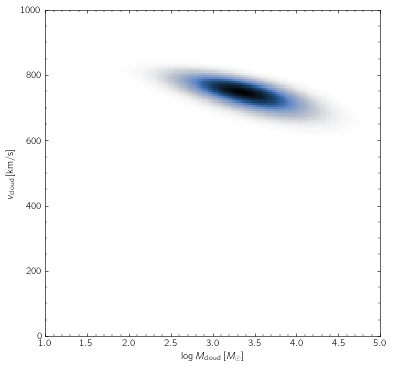

In [226]:
const = Const()
pm = Param("Inputs", const).paramDict

dr = 25 * pc
steps= 32

wind = Wind(dr, const, pm)
cloud = Cloud(dr, const, pm)


cloud_f = []
cloud_f.append(cloud.f)

r = []
wind_v = []
wind_rho = []
wind_P = []
r.append(wind.r)
wind_v.append(wind.v)
wind_rho.append(wind.rho)
wind_P.append(wind.P)

nflux = []
mass = []

for i_time in range(steps):
    cloud.step(wind)
    cloud_f.append(cloud.f)
    nflux.append(cloud.integrateNFlux())
    mass.append(cloud.integrateMass())
    wind.step()
    r.append(wind.r)
    wind_v.append(wind.v)
    wind_rho.append(wind.rho)
    wind_P.append(wind.P)
    
    if i_time % 10 == 0:
        print(i_time)

        
plt.figure(figsize=(6,6))
plt.pcolormesh(np.log10(cloud.mbin/Msun),cloud.vbin/km,np.reshape(cloud.f,(cloud.ncells_v,cloud.ncells_M)), cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
plt.xlim((cloud.M_min,cloud.M_max))
plt.ylim((cloud.v_min,cloud.v_max))

In [227]:
nflux

[3.5099403332417067e+23,
 2.6572494763365956e+23,
 2.167758671877063e+23,
 1.8460821223059487e+23,
 1.616300449699381e+23,
 1.4428364577243855e+23,
 1.3066573292605096e+23,
 1.1965771650328408e+23,
 1.1060812270904532e+23,
 1.0303537478261993e+23,
 9.65948394968811e+22,
 9.104299291687616e+22,
 8.620250201339114e+22,
 8.194094526206675e+22,
 7.815730505139894e+22,
 7.477309288916003e+22,
 7.172634400355657e+22,
 6.896744858994041e+22,
 6.645619273714872e+22,
 6.415961630262583e+22,
 6.2050434861122265e+22,
 6.010585888068258e+22,
 5.830669761775539e+22,
 5.663667036618557e+22,
 5.508187091297536e+22,
 5.3630346691446424e+22,
 5.227176484080808e+22,
 5.0997144846043045e+22,
 4.9798642707782254e+22,
 4.866937537106887e+22,
 4.760327688304138e+22,
 4.659497976078744e+22]

In [220]:
mflux

[1.007400747907549e+53,
 6.456483780779126e+52,
 4.927700814679987e+52,
 4.095148262912219e+52,
 3.5671579006023774e+52,
 3.19890986886223e+52,
 2.925246574971901e+52,
 2.71252790913764e+52,
 2.5421535761813164e+52,
 2.4020814275756634e+52,
 2.2843919414093903e+52,
 2.1837633179376832e+52,
 2.0964764124522995e+52,
 2.0198468886067778e+52,
 1.9518843057189263e+52,
 1.891078574658145e+52,
 1.836261293610317e+52,
 1.7865128818599803e+52,
 1.7410986966887248e+52,
 1.69942404534331e+52,
 1.6610018411363275e+52,
 1.6254289185055125e+52,
 1.5923684013136987e+52,
 1.5615363816949362e+52,
 1.5326917200270807e+52,
 1.5056281391894822e+52,
 1.4801680286524238e+52,
 1.4561575389477485e+52,
 1.433462661267118e+52,
 1.4119660671794346e+52,
 1.3915645406392392e+52,
 1.3721668757319452e+52]

In [99]:
ncells_v = 150
ncells_M = 150
dv_b = cloud.dv_b
dv_f = cloud.dv_f
dm_b = cloud.dm_b
dm_f = cloud.dm_f
mbin = cloud.mbin
x=cloud_f[0]
x_mtrx = x.reshape(150, 150)
v_delta = np.transpose(np.array([0.5*(dv_b+dv_f),]*ncells_M))
intv = (x_mtrx * mbin * v_delta).sum(axis=0)
intm_intv = sum(intv * 0.5 *(dm_b + dm_f))
intm_intv       

f=cloud_f[0]
#res, integrand = cloud.integrateMass(f)
#f[0], integrand[0], (np.tile(cloud.mbin, cloud.ncells_v) * f)[0], res / Msun
x_mtrx.shape
mbin.shape

sum(x * np.tile(mbin, 150) * np.tile(dm_b,150) * np.repeat(dv_b,150))/Msun, intm_intv
cloud.integrateMass()/Msun, cloud.integrateNFlux()

(4.330427517584225e+19, 4.4722867669046185e+22)

(0, 1000)

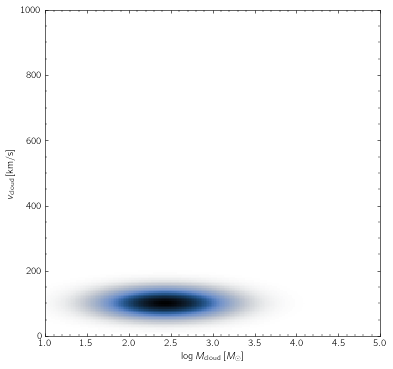

In [195]:
f = cloud_f[0]
plt.figure(figsize=(6,6))
plt.pcolormesh(np.log10(cloud.mbin/Msun),cloud.vbin/km,np.reshape(f,(cloud.ncells_v,cloud.ncells_M)), cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
plt.xlim((cloud.M_min,cloud.M_max))
plt.ylim((cloud.v_min,cloud.v_max))

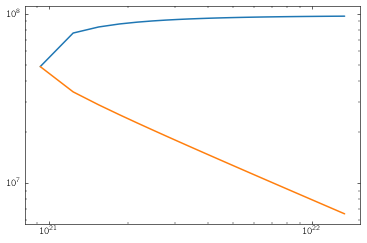

In [9]:
plt.loglog(r, wind_v)
plt.loglog(r, np.sqrt(gamma * np.array(wind_P) / np.array(wind_rho)))

(0, 1200)

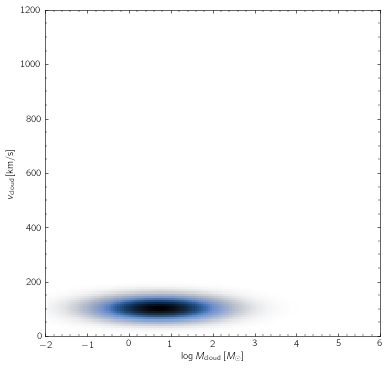

In [10]:

fn = cloud_f[0]
plt.figure(figsize=(6,6))
plt.pcolormesh(np.log10(cloud.mbin/Msun),cloud.vbin/km,np.reshape(fn,(cloud.ncells_v,cloud.ncells_M)), cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
plt.xlim((cloud.M_min,cloud.M_max))
plt.ylim((cloud.v_min,cloud.v_max))

In [11]:
Param("Inputs", const).paramDict

{'#': 'multiphase',
 'V_CELLS': 150,
 'M_CELLS': 150,
 'R_CELLS': 150,
 'V_MAX': 1200,
 'V_MIN': 0,
 'V_MU': 100.0,
 'V_SIGMA': 30.0,
 'M_MAX': 6,
 'M_MIN': -2,
 'M_MU': 3.0,
 'M_SIGMA': 1.0,
 'CLOUD_MASS': 1e+20,
 'WIND_MU': 0.62,
 'WIND_METALLICITY': '1E-0.5',
 'SFR': 1.2683916793505834e+27,
 'EDOT': 5.999999999999999e+42,
 'BETA': 1.0,
 'ALPHA': 1.0,
 'GAMMA': 1.4,
 'SONIC_POINT': 9.258e+20,
 'R_START': 9.258e+20,
 'COOL_FILE': 'Lambda_tab_redshifts.npz',
 'MDOT': 1.2683916793505834e+27}

In [15]:
a=np.array([1,2,3])

In [21]:
np.tile(a,4)

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])